In [1]:
# Import Dependencies and Load File
import numpy
import os
import json
import pdfplumber


file_dir = r'../floor plans/'
fps = os.listdir(file_dir)

print(len(fps))

floor_plans = {}

floor_plans[0] = pdfplumber.open(file_dir +fps[1]).pages[0]
im = floor_plans[0].to_image(resolution = 100)

20


In [2]:
# Manually Search for an example of a symbol

# Searching for objects within an area of the pdf
# Finding an index of a specified symbol and used below
# This is assuming that all relevant objects are curves and not line
# May not be the Case! (fix)

def find_all_segs(fp, xmin, xmax, ymin, ymax):
    segments = {}
    for i in range(0, len(fp.curves)):
        curve = fp.curves[i]
        
        if curve['y1'] > ymin and curve['y1'] < ymax:
            if curve['x1'] > xmin and curve['x1'] < xmax:
                segments[i] = curve
    
    return segments

dict_keys([6724, 7216, 7217, 7218, 7219, 8242, 8243, 8244, 8246, 8255, 8270])


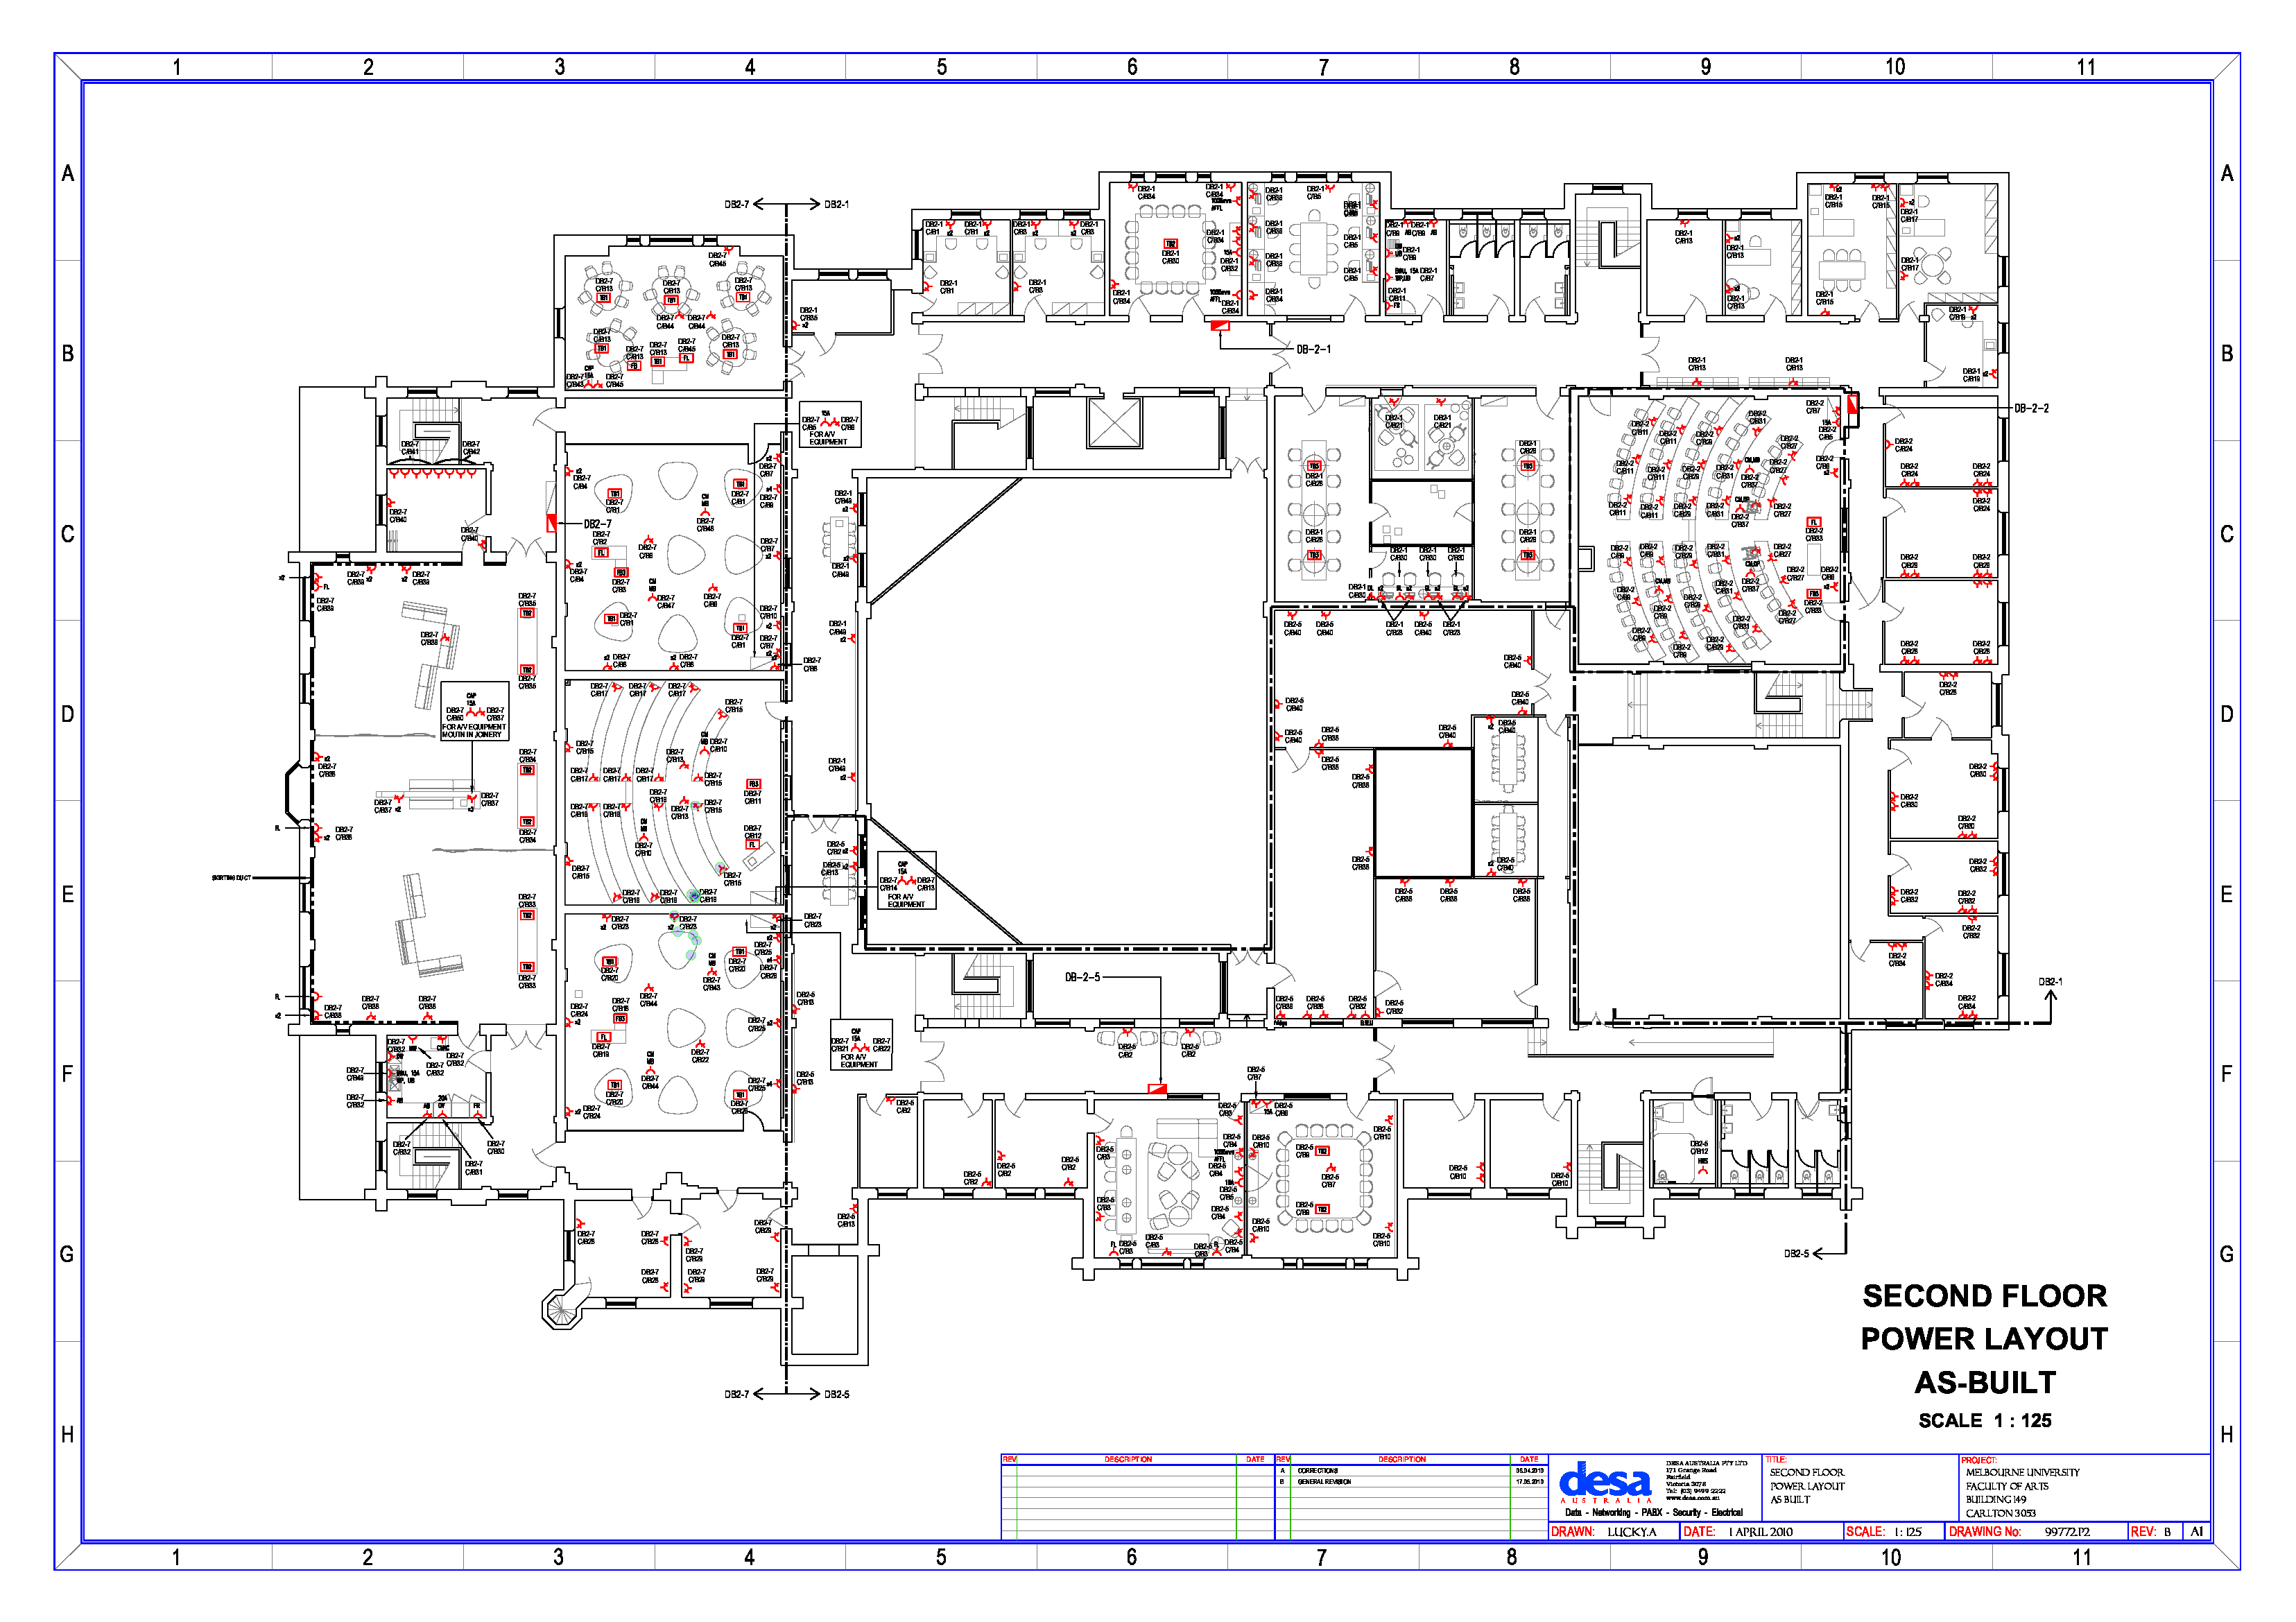

In [3]:
# confirm by visualising the floorplan with the symbol highlighted
segs = find_all_segs(floor_plans[0], 700, 750, 700, 850)
print(segs.keys())
im.reset()
for s in segs.keys():
    im.draw_circle(floor_plans[0].curves[s], stroke = "#66FF66")
im

In [4]:
print(floor_plans[0].curves[6463]['pts'])

[(Decimal('856.348'), Decimal('1114.699')), (Decimal('856.372'), Decimal('1114.661')), (Decimal('856.400'), Decimal('1114.627')), (Decimal('856.431'), Decimal('1114.596'))]


In [5]:
# rotates the orietation of the object to be aligned with 0, all objects will now be uniform
# score is then based on the magnitude from the first point to the rest 
# it just works

def rotate_points(fp, idx):
    pts = fp.curves[idx]['pts']
    n_dict = {}
    
    for i in range(0, len(pts)):
        n_dict[i] = {'x': float(pts[i][0] - pts[0][0]), 'y': float(pts[i][1] - pts[0][1])}

    theta = numpy.arctan2(float(n_dict[len(n_dict)-1]['y']), float(n_dict[len(n_dict)-1]['x']))
    c, s = numpy.cos(theta), numpy.sin(theta)
    R = numpy.array(((c, -s), (s, c)))
    
    vals = {}
    for i in range(0, len(n_dict)):
        coords = numpy.round(R.dot(numpy.array([n_dict[i]['x'], n_dict[i]['y']]).reshape(2,1)), 3)
        vals[i] = numpy.round(numpy.sqrt(coords[0] **2 + coords[1] ** 2), 3)[0]
        
    return vals

In [6]:
v1 = rotate_points(floor_plans[0], 8242)
print(v1)

v2 = rotate_points(floor_plans[0], 8302)
print(v2)

v3 = rotate_points(floor_plans[0], 8284)
print(v3)

score = 0
for i in range(0, len(v1)):
    sub = (v1[i] - v2[i]) **2
    score += sub
    
print(round(score, 3))

{0: 0.0, 1: 2.282, 2: 4.54, 3: 5.85, 4: 7.645, 5: 8.588, 6: 8.283}
{0: 0.0, 1: 2.29, 2: 4.535, 3: 5.855, 4: 7.648, 5: 8.591, 6: 8.28}
{0: 0.0, 1: 2.282, 2: 4.536, 3: 5.85, 4: 7.648, 5: 8.586, 6: 8.283}
0.0


In [7]:
# creates the template of the asset to be searched for
def create_symbol_sig(fp,idx, n_parts):
    ppoint = {}
    for i in range(0, n_parts):
        ppoint[i] = rotate_points(fp, idx + i)
    return ppoint

sig_0 = create_symbol_sig(floor_plans[0], 8242, 3)

sig_0

{0: {0: 0.0, 1: 2.282, 2: 4.54, 3: 5.85, 4: 7.645, 5: 8.588, 6: 8.283},
 1: {0: 0.0, 1: 4.106},
 2: {0: 0.0, 1: 4.58}}

In [8]:
# serialise the symbol as an object in a JSON file.
#JSON Structure

# { Symbol_Family :{
#       Symbol_name : {
#               obj_0 : {
#                   0 : n
#                   1 : n
#                   ...
#               },
#               ...
#           }, 
#           ...
#       }, 
#       ...
# }

# adds the template to the dictionary of templates which can then be jsonified
def add_sig(family, name, signature, d = None):
    if d == None:
        d = {family : {name : signature}}
    
    else:
        d[family][name] = signature
    
    return d
        
    
d_sig = add_sig('elec', 'elec_1', sig_0)
d_sig

{'elec': {'elec_1': {0: {0: 0.0,
    1: 2.282,
    2: 4.54,
    3: 5.85,
    4: 7.645,
    5: 8.588,
    6: 8.283},
   1: {0: 0.0, 1: 4.106},
   2: {0: 0.0, 1: 4.58}}}}